In [1]:
from functions import *
from architectures import *

%load_ext autoreload
%autoreload 2

C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:7: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import (to_datetime, Int64Index, DatetimeIndex, Period,
C:\ProgramData\Anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:7: FutureWarning: pandas.Float64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import (to_datetime, Int64Index, DatetimeIndex, Period,


## -----------------------------------------------------------------------------------------------------------------------------

## By ['SKU_id', 'Store_id']

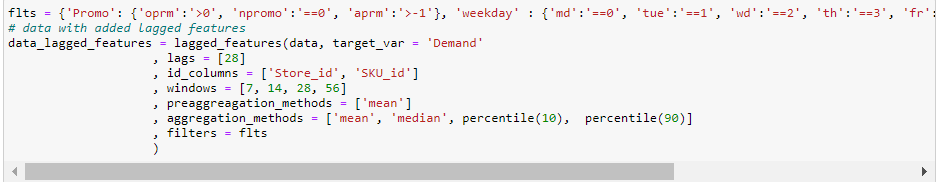

In [3]:
data_lagged_features = pd.read_csv('notoptshit.csv')
data_lagged_features['Date'] = pd.to_datetime(data_lagged_features['Date'])

In [5]:
for c in tqdm(data_lagged_features.drop(['Date', 'Demand', 'Store_id', 'SKU_id'], axis=1).columns):
    a = data_lagged_features[[c, 'Store_id', 'SKU_id', 'Date']].groupby(['Store_id', 'SKU_id']).apply(lambda x : x.set_index('Date').rolling('5D', min_periods=1).mean())[[c]].reset_index()
    merged = data_lagged_features.merge(a, on=['Store_id', 'SKU_id', 'Date'])
    data_lagged_features.loc[data_lagged_features[c].isna(), c] = merged[data_lagged_features[c].isna()][c+'_y']

100%|██████████████████████████████████████████████████████████████████████████████████| 72/72 [00:18<00:00,  3.87it/s]


In [6]:
from tqdm.contrib.itertools import product

for c, store, sku in product(data_lagged_features.drop(['Date', 'Demand'], axis=1).columns,
                      data_lagged_features['Store_id'].unique(), data_lagged_features['SKU_id'].unique()):
    cond = (data_lagged_features['SKU_id'] == sku) & (data_lagged_features['Store_id'] == store)
    data_lagged_features.loc[cond, c] = data_lagged_features[cond][c].fillna(data_lagged_features[cond][c].mean())

  0%|          | 0/16280 [00:00<?, ?it/s]

In [7]:
for c in data_lagged_features.drop(['Date', 'Demand'], axis=1).columns:
    for sku in data_lagged_features['SKU_id'].unique():
        cond = (data_lagged_features['SKU_id'] == sku)
        data_lagged_features.loc[cond, c] = data_lagged_features[cond][c].fillna(data_lagged_features[cond][c].mean())

In [8]:
df_train, df_test, target_mean, target_stdev, target, features = preprocess(data_lagged_features)

In [9]:
set_random_seed(7)

In [10]:
batch_size = 128
sequence_length = 30

train_dataset = SequenceDataset(
    df_train,
    target=target,
    features=features,
    sequence_length=sequence_length
)
test_dataset = SequenceDataset(
    df_test,
    target=target,
    features=features,
    sequence_length=sequence_length
)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=512, shuffle=False)
train_eval_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=False)

X, y = next(iter(train_loader))

print("Features shape:", X.shape)
print("Target shape:", y.shape)

Features shape: torch.Size([128, 30, 72])
Target shape: torch.Size([128])


In [58]:
params = {
    'learning_rate' : 1e-3,
    'weight_decay' : 1e-5,
    'num_hidden_units' : 64,
    'loss_function' : nn.L1Loss(),
    'gamma' : 0.95,
    'shape' : data_lagged_features.shape,
    'epochs' : 5
}

model = GRU(num_sensors=len(features), hidden_units=params['num_hidden_units'])
loss_function = params['loss_function']
optimizer = torch.optim.Adam(model.parameters(), lr=params['learning_rate'], weight_decay=params['weight_decay'])
scheduler = torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma=params['gamma'])

In [59]:
#params['epochs'] = 1
epochs = params['epochs']

train(df_train, epochs, train_loader, train_eval_loader,model,
      loss_function, optimizer, scheduler, batch_size, target_mean, target_stdev)

Epoch 0
---------


100%|████████████████████████████████████████████████████████████████████████████████| 680/680 [01:06<00:00, 10.26it/s]


Train loss: 0.26094971761545716


100%|████████████████████████████████████████████████████████████████████████████████| 680/680 [00:25<00:00, 26.37it/s]


Smape = 101.38021759574555

Epoch 1
---------


100%|████████████████████████████████████████████████████████████████████████████████| 680/680 [01:32<00:00,  7.33it/s]


Train loss: 0.22801329423399533


100%|████████████████████████████████████████████████████████████████████████████████| 680/680 [00:21<00:00, 32.07it/s]


Smape = 87.9270715886392

Epoch 2
---------


100%|████████████████████████████████████████████████████████████████████████████████| 680/680 [01:34<00:00,  7.16it/s]


Train loss: 0.22321315718924298


100%|████████████████████████████████████████████████████████████████████████████████| 680/680 [01:15<00:00,  9.00it/s]


Smape = 81.832595041369

Epoch 3
---------


100%|████████████████████████████████████████████████████████████████████████████████| 680/680 [01:52<00:00,  6.03it/s]


Train loss: 0.2192299543715575


100%|████████████████████████████████████████████████████████████████████████████████| 680/680 [01:14<00:00,  9.14it/s]


Smape = 83.26668915960367

Epoch 4
---------


100%|████████████████████████████████████████████████████████████████████████████████| 680/680 [01:51<00:00,  6.08it/s]


Train loss: 0.2166260665830444


100%|████████████████████████████████████████████████████████████████████████████████| 680/680 [01:14<00:00,  9.10it/s]

Smape = 86.28443337784024



In [60]:
df_out = get_df_out(model, df_train, df_test, train_eval_loader, test_loader, target, target_mean, target_stdev)
ans = get_submission('test_kaggle.csv', df_out)

100%|██████████████████████████████████████████████████████████████████████████████████| 12/12 [00:04<00:00,  2.67it/s]


In [61]:
ans_sku = pd.read_csv('68.csv')

In [62]:
ans.loc[ans['Demand'].isna(), 'Demand'] = ans_sku[ans.reset_index()['Demand'].isna()]['Demand'].values

In [63]:
ans.to_csv('submission_sku_store3.csv', index_label='id')

<AxesSubplot:xlabel='Date'>

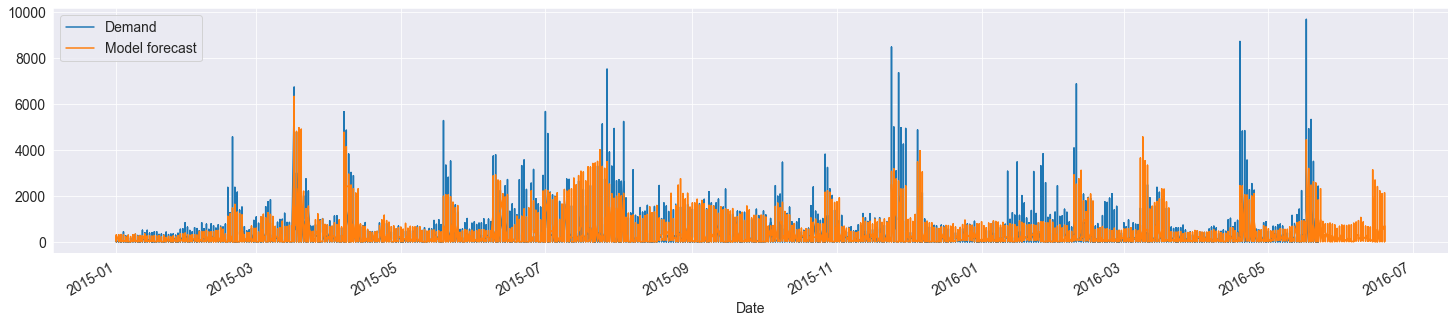

In [64]:
df_out.reset_index().drop(['Store_id', 'SKU_id'], axis=1).set_index('Date').sort_index().plot()

## -----------------------------------------------------------------------------------------------------------------------------